In [9]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

Methods

In [15]:
def read_images(filelist):
    for file in filelist:     
        image = cv2.imread(file)
        yield image


def get_images(data_path):   
        #this path depends on how you have kept the images 
        impath = os.path.join(data_path, "image_2", "*.png")  
        imlist = sorted(glob.glob(impath))
        
        cam2 = read_images(imlist)
        
        impath = os.path.join(data_path, "image_3", "*.png")
        imlist = sorted(glob.glob(impath))
        cam3 = read_images(imlist)
        
        

        return zip(cam2, cam3)

#red_calib_file() is from https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py

def read_calib_file(filepath):
    data = {}

    with open(filepath, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

def get_disparity(left_image, right_image):
   
    window_size = 9
    minDisparity = 1
    stereo = cv2.StereoSGBM_create(
        blockSize=10,
        numDisparities=64,
        preFilterCap=10,
        minDisparity=minDisparity,
        P1=4 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2
    )
    
   
  
    return stereo.compute(left_image , right_image)

#http://pointclouds.org/documentation/tutorials/pcd_file_format.php
def write_pcd(points,  fname = 'test.pcd'):
    points = list(points)
    size = len(points)
    f = open(fname, 'w')
    header = """# .PCD v.7 - Point Cloud Data file format
    VERSION .7
    FIELDS x y z 
    SIZE 4 4 4 
    TYPE F F F 
    COUNT 1 1 1 
    WIDTH %(size)d
    HEIGHT 1
    VIEWPOINT 0 0 0 1 0 0 0
    POINTS %(size)d
    DATA ascii
    """ % { "size" : size }
    f.write(header)
    for i in range(size):
        f.write("%f %f %f \n" % ( points[i][0], points[i][1], (points[i][2]) ))  
    f.close
    print('Done writing %s' % (fname)) 


Defining path to read images

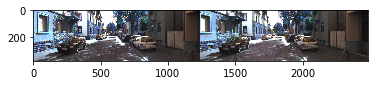

In [16]:
images_path = '/home/shashank/prog/python/data3/'
calib_filepath = '/home/shashank/prog/python/data3/calib_cam_to_cam.txt'

data = get_images(images_path)
values = read_calib_file(calib_filepath)

image_set = next(data)
plt.imshow( np.hstack( (image_set[0],image_set[1]) ) )

<hr>
<p>
S_xx: 1x2 size of image xx before rectification <br>
K_xx: 3x3 calibration matrix of camera xx before rectification <br>
D_xx: 1x5 distortion vector of camera xx before rectification <br>
R_xx: 3x3 rotation matrix of camera xx (extrinsic) <br>
T_xx: 3x1 translation vector of camera xx (extrinsic) <br>
S_rect_xx: 1x2 size of image xx after rectification <br>
R_rect_xx: 3x3 rectifying rotation to make image planes co-planar <br>
P_rect_xx: 3x4 projection matrix after rectification <br>
</p>
<hr>
https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT <br />
https://stackoverflow.com/questions/29407474/how-to-understand-kitti-camera-calibration-files/41273370 <br />

In [17]:


#rotation matrx 3x3

cam2_R = values['R_rect_02'].reshape(3,3)
cam3_R = values['R_rect_03'].reshape(3,3)

#transalation vector 3x1
cam2_T = np.transpose(np.matrix(values['T_02']))
cam3_T = np.transpose(np.matrix(values['T_03']))

#calibration matrix 3x3


cam2_K = values['K_02'].reshape(3,3)
cam3_K = values['K_03'].reshape(3,3)

#distortion coeff 1x5
cam2_D = np.matrix(values['D_02'])
cam3_D = np.matrix(values['D_03'])




IMG_SIZE = (1242, 375)

cam2_R = np.linalg.inv(cam2_R)
rotation = np.dot(cam2_R  ,cam3_R)
translation = cam2_T - cam3_T
# output matrices from stereoRectify init
R1 = np.zeros(shape=(3, 3))
R2 = np.zeros(shape=(3, 3))
P1 = np.zeros(shape=(3, 4))
P2 = np.zeros(shape=(3, 4))
Q = np.zeros(shape=(4, 4))




R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(cam2_K, cam2_D, cam3_K, cam3_D, IMG_SIZE, rotation, translation,R1, R2, P1, P2, Q)
Q[2][3]*=-1
print(Q)

[[   1.            0.            0.         -519.12366486]
 [   0.            1.            0.         -135.5802021 ]
 [   0.            0.            0.         -929.4452    ]
 [   0.            0.            1.87703644   -0.        ]]


Done writing test.pcd


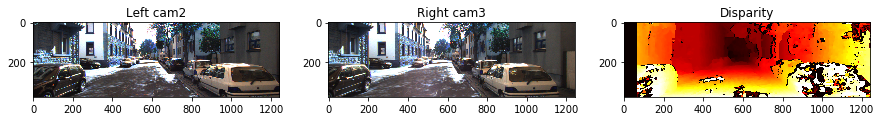

In [22]:
for image_set in data:
    disp = get_disparity(image_set[0], image_set[1])  
    
    f, ax = plt.subplots(1,3, figsize=(15, 5))
    ax[0].imshow(image_set[0])
    ax[0].set_title('Left cam2')

    ax[ 1].imshow(image_set[1])
    ax[ 1].set_title('Right cam3')
    
    ax[2].imshow(disp, cmap = 'hot')
    ax[2].set_title('Disparity')
    
    
    points = cv2.reprojectImageTo3D(disp, Q, True)
   
    mask = disp > disp.min()
    out_points = points[mask]
    
    out_points = out_points.reshape(-1,3)
    write_pcd(out_points)
    break
    
    

#### To view pcd 

` sudo apt install pcl-tools `

` pcl_viewer test.pcd `

### References

- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_depthmap/py_depthmap.html
- http://timosam.com/python_opencv_depthimage
- https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py


In [14]:
points

array([[       -inf,        -inf,        -inf],
       [       -inf,        -inf,        -inf],
       [       -inf,        -inf,        -inf],
       ...,
       [ 0.37452883,  0.12404226, -0.48356083],
       [ 0.37504908,  0.12404226, -0.48356083],
       [ 0.37556934,  0.12404226, -0.48356083]], dtype=float32)